# Numerical Schemes for hyperbolic PDEs


\begin{equation}
\rho(x,0) = \left\{
\begin{array}{cc}
0.5 \rho_{\rm max} & 0 \leq x < 3  \\
\rho_{\rm max} & 3 \leq x \leq 4 \\
\end{array}
\right.
\end{equation}

In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline

import ipywidgets

In [2]:
# set the font family and size to use for Matplotlib figures
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
def rho_red_light(x, rho_max):
    """
    Computes the "red light" initial condition with shock.
    
    Parameters
    ----------
    x : numpy.ndaray
        Locations on the road as a 1D array of floats
    rho_max : float
        The maximum traffic density allowed
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road as 1D array of floats
    """
    
    rho = rho_max * np.ones_like(x)
    mask = np.where(x < 3.0)
    rho[mask] = 0.5 * rho_max
    
    return rho

In [4]:
# set parameters
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
nt = 40  # number of time steps to compute
rho_max = 10.0  # maximum taffic density allowed
u_max = 1.0  # maximum speed traffic

# get the road locations
x = np.linspace(0.0, L, num=nx)

# compute the initial traffic density
rho0 = rho_red_light(x, rho_max)

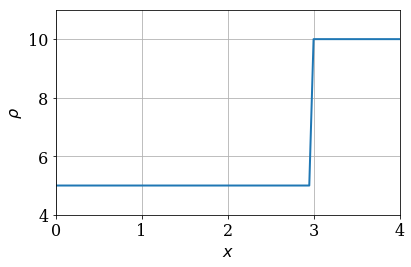

In [5]:
# plot ICs
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

In [6]:
def flux(rho, u_max, rho_max):
    """
    Computes the traffic flux F = V * rho.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats
    u_max : float
        Maximum speed allowed on the road
    rho_max : float
        Maximum car density allowed on the road
    
    Returns
    -------
    F : numpy.ndarray
        The traffic flux along the road as a 1D array of floats
    """
    
    F = rho * u_max * (1.0 - rho / rho_max)
    
    return F

In [7]:
from matplotlib import animation
from IPython.display import HTML

In [8]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution
    """
    
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

## Lax-Friedrichs Scheme
\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}

with
\begin{equation}
F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)
\end{equation}.

Time moves forward, choose forward difference for time variable:
\begin{equation}
\frac{\partial \rho}{\partial t}\approx \frac{1}{\Delta t}( \rho_i^{n+1}-\rho_i^n )
\end{equation}

The simplest approach to get second-order accuracy in space is to use a central difference:
\begin{equation}
\frac{\partial F}{\partial x} \approx \frac{1}{2\Delta x}( F_{i+1}-F_{i-1})
\end{equation}

But FTCS is **unstable!**

Lax-Friedrichs implementation makes the FTCS stable. The idea was to replace the solution value at $\rho_i^n$ by the average of the values at the neighboring grid points. 
That is,
\begin{equation}
\frac{\rho_i^{n+1}-\frac{1}{2}(\rho^n_{i+1}+\rho^n_{i-1})}{\Delta t} = -\frac{F^n_{i+1}-F^n_{i-1}}{2 \Delta x}.
\end{equation}

\begin{equation}
\rho_i^{n+1} = \frac{1}{2}(\rho^n_{i+1}+\rho^n_{i-1}) - \frac{\Delta t}{2 \Delta x}(F^n_{i+1}-F^n_{i-1})
\end{equation}

This  is **stable!**

In [9]:
def lax_friedrichs(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road at a certain time given 
    the initial traffic density. Integration using Lax-Friedrichs scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road as a 1D array of floats
    nt : integer
        The number of time steps to compute
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations
    args : list or tuple
        Positional arguments to be passed to the flux function
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road
    """
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        
        # compute the flux
        F = flux(rho, *args)
        
        # advance in time using Lax-Friedrichs scheme
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]))
        
        # set the value at the first location
        rho[0] = bc_values[0]
        
        # set the value at the last location
        rho[-1] = bc_values[1]
        
        # Record the time-step solution
        rho_hist.append(rho.copy())
        
    return rho_hist

### Lax-Friedrichs with $\frac{\Delta t}{\Delta x}=1$

In [10]:
# set the time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [11]:
def plot_density(n, rho_hist):
    fix, ax = pyplot.subplots(figsize=(8.0, 4.0))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'$\rho$')
    ax.plot(x, rho_hist[0], label='initial', color='C0', linestyle='--', linewidth=2)
    ax.plot(x, rho_hist[n], label='time step', color='C1', linewidth=2)
    ax.set_ylim([4.5, 11])

In [12]:
nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
display(ipywidgets.interactive(plot_density, n=nt_slider, rho_hist=ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [13]:
# animation
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# display the video
HTML(anim.to_html5_video())

### Lax-Friedrichs with $\frac{\Delta t}{\Delta x}=0.5$

In [14]:
# set the time-step size based on CFL limit
sigma = 0.5
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [15]:
nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
display(ipywidgets.interactive(plot_density, n=nt_slider, rho_hist=ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [16]:
# animation
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# display the video
HTML(anim.to_html5_video())

## Lax-Wendroff Scheme

* Lax-Friedrichs method
    * Stabilizes the central difference in space for convection.
    * Looses an order of accuray.
* First-order methods are just not good enough for convection problems, especially when you have sharp gradients (shocks).
* The Lax-Wendroff (1960) method was the first scheme ever to achieve second-order accuracy in **both** space and time.

\begin{align}
&\rho_i^{n+1} = \rho_i^n - \frac{\Delta t}{2 \Delta x} \left(F^n_{i+1}-F^n_{i-1}\right) + \cdots \\ \nonumber 
&+ \frac{(\Delta t)^2}{4(\Delta x)^2} \left[ (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right]
\end{align}

with
\begin{equation}J^n_i = \frac{\partial F}{\partial \rho} = u_{\rm max} \left(1-2\frac{\rho^n_i}{\rho_{\rm max}} \right).\end{equation}

In [17]:
def jacobian(rho, u_max, rho_max):
    """
    Computes the Jacobian for traffic model.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats
    u_max : float
        Maximum speed allowed on the road
    rho_max : float
        Maximum car density allowed on the road
    
    Returns
    -------
    J : numpy.ndarray
        The Jacobian as a 1D array of floats
    """
    
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    
    return J

In [18]:
def lax_wendroff(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road  at a certain time given the initial traffic 
    density. Integration using Lax-Wendroff scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road as a 1D array of floats
    nt : integer
        The number of time steps to compute
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations
    args : list or tuple
        Positional arguments to be passed to the flux and Jacobien functions
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road
    """
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        
        # compute the flux
        F = flux(rho, *args)
        
        # compute the Jacobian
        J = jacobian(rho, *args)
        
        # advance in time using Lax-Wendroff scheme
        rho[1:-1] = (rho[1:-1]
                     - dt / (2.0 * dx) * (F[2:] - F[:-2])
                     + dt**2 / (4.0 * dx**2) *
                     ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1])
                       - (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        
        # set the value at the first location
        rho[0] = bc_values[0]
        
        # set the value at the last location
        rho[-1] = bc_values[1]
        
        # record the time-step solution
        rho_hist.append(rho.copy())
        
    return rho_hist

### Lax-Wendroff with $\frac{\Delta t}{\Delta x}=1$

In [19]:
# set the time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [20]:
nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
display(ipywidgets.interactive(plot_density, n=nt_slider, rho_hist=ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [21]:
# animation
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# display the video
HTML(anim.to_html5_video())

### Lax-Wendroff with $\frac{\Delta t}{\Delta x}=0.5$

In [22]:
# set the time-step size to 0.5
sigma = 0.5
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [23]:
nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
display(ipywidgets.interactive(plot_density, n=nt_slider, rho_hist=ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

## MacCormack Scheme

*  The main drawback of the Lax-Wendroff method: having to calculate the Jacobian in every time step => computationally expensive
* Two step process:
    * predictor: $\rho^*_i = \rho^n_i - \frac{\Delta t}{\Delta x} (F^n_{i+1}-F^n_{i})$
    * corrector: $\rho^{n+1}_i = \frac{1}{2} (\rho^n_i + \rho^*_i - \frac{\Delta t}{\Delta x} (F^*_i - F^{*}_{i-1}))$
* First step: FTFS
* Second step: FTBS
* Because of this, MacCormack scheme is stable for both right and left running waves.

In [24]:
def maccormack(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road  at a certain time given the initial 
    traffic density. Integration using MacCormack scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road as a 1D array of floats
    nt : integer
        The number of time steps to compute
    dt : float
        The time-step size to integrate
    dx : float
        The distance between two consecutive locations
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations
    args : list or tuple
        Positional arguments to be passed to the flux function
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road
    """
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    
    for n in range(nt):
        # compute the flux
        F = flux(rho, *args)
        
        # predictor step of the MacCormack scheme
        rho_star[1:-1] = (rho[1:-1] - dt / dx * (F[2:] - F[1:-1]))
        
        # compute the flux
        F = flux(rho_star, *args)
        
        # corrector step of the MacCormack scheme
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] - dt / dx * (F[1:-1] - F[:-2]))
        
        # set the value at the first location
        rho[0] = bc_values[0]
        
        # set the value at the last location
        rho[-1] = bc_values[1]
        
        # record the time-step solution
        rho_hist.append(rho.copy())
        
    return rho_hist

### MacCormack with $\frac{\Delta t}{\Delta x} = 1$

In [25]:
# set the time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [26]:
nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
display(ipywidgets.interactive(plot_density, n=nt_slider, rho_hist=ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [27]:
# set the time-step size based on CFL limit
sigma = 0.5
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [28]:
nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
display(ipywidgets.interactive(plot_density, n=nt_slider, rho_hist=ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

## Challenge Task


In [29]:
def rho_red_light_challenge(x, rho_max):
    """
    Computes the "red light" initial condition with shock.
    
    Parameters
    ----------
    x : numpy.ndaray
        Locations on the road as a 1D array of floats
    rho_max : float
        The maximum traffic density allowed
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road as 1D array of floats
    """
    
    rho = rho_max * np.ones_like(x)
    mask = np.where(x < 3.0)
    rho[mask] = 0.1 * rho_max
    
    return rho

# compute the initial traffic density
rho0 = rho_red_light_challenge(x, rho_max)


def plot_density(n, rho_hist):
    fix, ax = pyplot.subplots(figsize=(8.0, 4.0))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'$\rho$')
    ax.plot(x, rho_hist[0], label='initial', color='C0', linestyle='--', linewidth=2)
    ax.plot(x, rho_hist[n], label='time step', color='C1', linewidth=2)
    ax.set_ylim([0, 11])

In [30]:
# set the time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
display(ipywidgets.interactive(plot_density, n=nt_slider, rho_hist=ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [31]:
# set the time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
display(ipywidgets.interactive(plot_density, n=nt_slider, rho_hist=ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [32]:
# set the time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# compute the traffic density at all time steps
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
display(ipywidgets.interactive(plot_density, n=nt_slider, rho_hist=ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

We can see overshoots in both $\rho_{max}$ and $\rho_{in}$. 